# 

# Merging and Reshaping Data

In this chapter, we continue to look at some of the ways to manipulate
data using the **tidyverse** packages. In particular, we look at
reshaping and merging data frames in order to get the data in the format
we want. When reshaping data, we can convert between *wide form* (more
columns, fewer rows) and *long form* (fewer columns, more rows). We can
also use data pivots to put our data into what is called *tidy form*.
Additionally, we look at combining information from multiple data frames
into a single data frame. The key ideas when merging data are to think
about what the common information is between the data frames and to
consider which values we want to keep.

For this chapter, we use three data sets. The first data set is
`covidcases`, which contains the weekly COVID-19 case and death counts
by county in the United States for 2020 \[@covid_data; @covid_article\];
the second data set is `mobility`, which contains daily mobility
estimates by state in 2020 \[@warren2020mobility\]; and the third data
set is `lockdowndates`, which contains the start and end dates for
statewide stay at home orders \[@covid_policy\]. Take a look at the
first few rows of each data frame and read the documentation for the
column descriptions.

In [ ]:
library(tidyverse)
library(HDSinRdata)

data(covidcases)
data(lockdowndates)
data(mobility)

In [ ]:
head(covidcases)

# A tibble: 6 × 5
  state   county   week weekly_cases weekly_deaths
  <chr>   <chr>   <dbl>        <int>         <int>
1 Alabama Autauga    12            3             0
2 Alabama Autauga    13            3             0
3 Alabama Autauga    14            2             1
4 Alabama Autauga    15           11             1
5 Alabama Autauga    16            5             1
6 Alabama Autauga    17            8             2

In [ ]:
head(mobility)

# A tibble: 6 × 5
# Groups:   state [1]
  state   date       samples   m50 m50_index
  <chr>   <chr>        <int> <dbl>     <dbl>
1 Alabama 2020-03-01  267652  10.9      76.9
2 Alabama 2020-03-02  287264  14.3      98.6
3 Alabama 2020-03-03  292018  14.2      98.2
4 Alabama 2020-03-04  298704  13.1      89.7
5 Alabama 2020-03-05  288218  14.8     102. 
6 Alabama 2020-03-06  282982  17.9     126. 

In [ ]:
head(lockdowndates)

# A tibble: 6 × 3
  State      Lockdown_Start Lockdown_End
  <chr>      <chr>          <chr>       
1 Alabama    2020-04-04     2020-04-30  
2 Alaska     2020-03-28     2020-04-24  
3 Arizona    2020-03-31     2020-05-16  
4 Arkansas   None           None        
5 California 2020-03-19     2021-01-25  
6 Colorado   2020-03-26     2020-04-27  

Both the mobility and lockdown data frames contain date columns. Right
now, these columns in both data sets are of the class character, which
we can see in the printed output. We can use the `as.Date()` function to
tell R to treat these columns as dates instead of characters. When using
this function, we need to specify the date format as an argument so that
R knows how to parse this text to a date. Our format is given as
`%Y-%M-%D`, where the `%Y` stands for the full four-digit year, `%M` is
a two-digit month (e.g. January is coded “01” vs “1”), and `%D` stands
for the two-digit day (e.g. the third day is coded “03” vs “3”). In the
following code, we convert the classes of these columns to ‘Date’.

In [ ]:
mobility$date <- as.Date(mobility$date, formula = "%Y-%M-%D")
lockdowndates$Lockdown_Start <- as.Date(lockdowndates$Lockdown_Start, 
                                        formula = "%Y-%M-%D")
lockdowndates$Lockdown_End <- as.Date(lockdowndates$Lockdown_End, 
                                      formula = "%Y-%M-%D")
class(mobility$date)

[1] "Date"

[1] "Date"

[1] "Date"

After coding these columns as dates, we can access information such as
the day, month, year, or week from them. These functions are all
available in the **lubridate** package \[@R-lubridate\], which is a
package in the **tidyverse** that allows us to manipulate dates.

In [ ]:
month(mobility$date[1])

[1] 3

[1] 9

Next, we add a date column to `covidcases`. In this case, we need to use
the week number to find the date. Luckily, we can add days, months,
weeks, or years to dates using the **lubridate** package. January 1,
2020 was a Wednesday and is counted as the first week, so to find the
corresponding Sunday for each week, we add the recorded week number
minus one to December 29, 2019 (the last Sunday before 2020). We show a
simple example of adding one week to this date before doing this
conversion for the entire column.

In [ ]:
as.Date("2019-12-29") + weeks(1)

[1] "2020-01-05"

In [ ]:
covidcases$date <- as.Date("2019-12-29") + weeks(covidcases$week - 1)
head(covidcases)

# A tibble: 6 × 6
  state   county   week weekly_cases weekly_deaths date      
  <chr>   <chr>   <dbl>        <int>         <int> <date>    
1 Alabama Autauga    12            3             0 2020-03-15
2 Alabama Autauga    13            3             0 2020-03-22
3 Alabama Autauga    14            2             1 2020-03-29
4 Alabama Autauga    15           11             1 2020-04-05
5 Alabama Autauga    16            5             1 2020-04-12
6 Alabama Autauga    17            8             2 2020-04-19

## Tidy Data

The **tidyverse** is designed around interacting with **tidy data** with
the premise that using data in a tidy format can streamline our
analysis. Data is considered **tidy** if:

-   Each variable is associated with a single column.

-   Each observation is associated with a single row.

-   Each value has its own cell.

Take a look at the sample data which stores information about the
maternal mortality rate for five countries over time
\[@maternal_mortality\]. This data is *not* tidy because the variable
for maternity mortality rate is associated with multiple columns. Every
row should correspond to one class observation.

In [ ]:
mat_mort1 <- data.frame(country = c("Turkey", "United States", 
                                    "Sweden", "Japan"),
                       y2002 = c(64, 9.9, 4.17, 7.8),
                       y2007 = c(21.9, 12.7, 1.86, 3.6),
                       y2012 = c(15.2, 16, 5.4, 4.8))
head(mat_mort1)

        country y2002 y2007 y2012
1        Turkey 64.00 21.90  15.2
2 United States  9.90 12.70  16.0
3        Sweden  4.17  1.86   5.4
4         Japan  7.80  3.60   4.8

However, we can make this data tidy by creating separate columns for
country, year, and maternity mortality rate as we demonstrate in the
following code. Now every observation is associated with an individual
row.

In [ ]:
mat_mort2 <- data.frame(
    country = rep(c("Turkey", "United States", "Sweden", "Japan"), 3),
    year = c(rep(2002, 4), rep(2007, 4), rep(2012, 4)),
    mat_mort_rate = c(64.0, 9.9, 4.17, 7.8, 21.9, 12.7, 1.86, 3.6, 
                      15.2, 16, 5.4, 4.8))
head(mat_mort2)

        country year mat_mort_rate
1        Turkey 2002         64.00
2 United States 2002          9.90
3        Sweden 2002          4.17
4         Japan 2002          7.80
5        Turkey 2007         21.90
6 United States 2007         12.70

## Reshaping Data

The mobility and COVID-19 case data are both already in tidy form: each
observation corresponds to a single row, and every column is a single
variable. We might consider whether the lockdown dates should be
reformatted to be tidy. Another way to represent this data would be to
have each observation be the start or end of a stay at home order.

To reshape our data, we use the `pivot_longer()` function to change the
data from what is called **wide form** to what is called **long form**.
This kind of pivot involves taking a subset of columns that we want to
*gather* into a single column while increasing the number of rows in the
data set. Before pivoting, we have to think about which columns we are
transforming. The image in
<a href="#fig-pivot-long" class="quarto-xref">Figure 1</a> shows a
picture of some data on whether students have completed a physical,
hearing, or eye exam. The data is presented in wide form on the left and
long form on the right. To transform wide data to long data, we have
identified a subset of columns `cols` that we want to transform (these
`cols` are `phys`, `hear`, and `eye` in the left table). The long form
contains a new column `names_to` that contains the exam type and
`values_to` that contains a binary variable indicating whether or not
each exam was completed.

<figure id="fig-pivot-long">
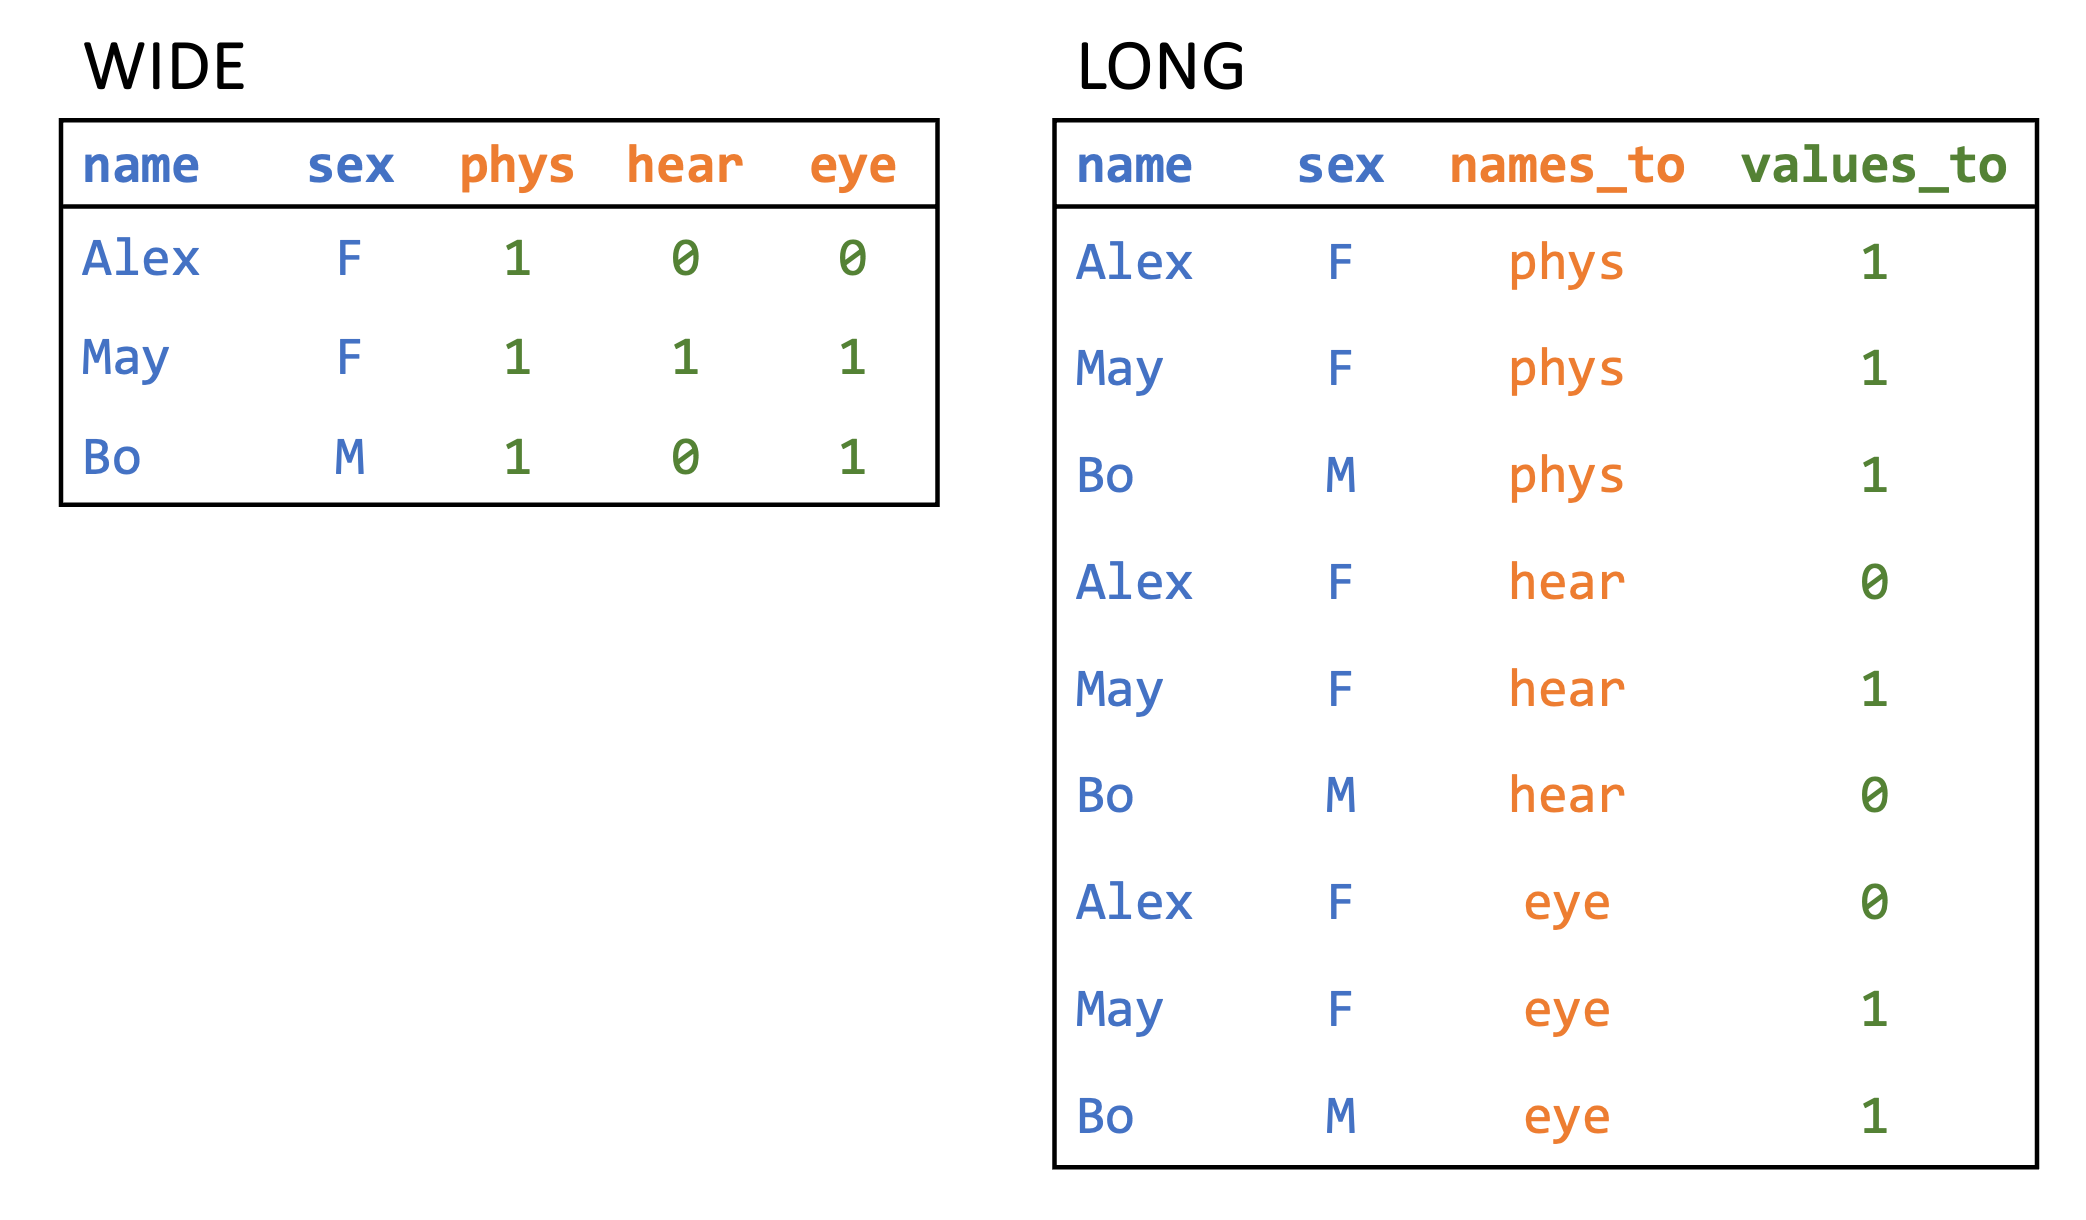
<figcaption>Figure 1: Pivoting Longer.</figcaption>
</figure>

In our case, we want to take the lockdown start and end columns and
create two new columns: one column will indicate whether or not a date
represents the start or end of a lockdown, and the other will contain
the date itself. These are called the *key* and *value* columns,
respectively. The key column gets its values from the names of the
columns we are transforming (or the keys) whereas the value column gets
its values from the entries in those columns (or the values).

The `pivot_longer()` function takes in a data table, the columns `cols`
that we are pivoting to longer form, the column name `names_to` that
will store the data from the previous column names, and the column name
`values_to` for the column that will store the information from the
columns gathered. In our case, we name the first column `Lockdown_Event`
since it will contain whether each date is the start or end of a
lockdown, and we name the second column `Date`. Take a look at the
result.

In [ ]:
lockdown_long <- lockdowndates %>%
  pivot_longer(cols = c("Lockdown_Start", "Lockdown_End"), 
               names_to = "Lockdown_Event", values_to = "Date") %>%
  mutate(Date = as.Date(Date, formula ="%Y-%M-%D"), 
         Lockdown_Event = ifelse(Lockdown_Event=="Lockdown_Start", 
                                 "Start", "End")) %>%
  na.omit()
head(lockdown_long)

# A tibble: 6 × 3
  State   Lockdown_Event Date      
  <chr>   <chr>          <date>    
1 Alabama Start          2020-04-04
2 Alabama End            2020-04-30
3 Alaska  Start          2020-03-28
4 Alaska  End            2020-04-24
5 Arizona Start          2020-03-31
6 Arizona End            2020-05-16

In R, we can also transform our data in the opposite direction (from
long form to wide form instead of from wide form to long form) using the
function `pivot_wider()`. This function again first takes in a data
table but now we specify the arguments `names_from` and `values_from`.
The former indicates the column that R should get the new column names
from, and the latter indicates where the row values should be taken
from. For example, in order to pivot our lockdown data back to wide form
in the following code, we specify that `names_from` is the lockdown
event and `values_from` is the date itself. Now we are back to the same
form as before!

In [ ]:
lockdown_wide <- pivot_wider(lockdown_long, 
                             names_from = Lockdown_Event, 
                             values_from = Date)
head(lockdown_wide)

# A tibble: 6 × 3
  State       Start      End       
  <chr>       <date>     <date>    
1 Alabama     2020-04-04 2020-04-30
2 Alaska      2020-03-28 2020-04-24
3 Arizona     2020-03-31 2020-05-16
4 California  2020-03-19 2021-01-25
5 Colorado    2020-03-26 2020-04-27
6 Connecticut 2020-03-23 2020-05-20

Here’s another example: suppose that I want to create a data frame where
the columns correspond to the number of cases for each state in New
England and the rows correspond to the numbered months. First, I need to
filter my data to New England and then summarize my data to find the
number of cases per month. I use the `month()` function to be able to
group by month and state. Additionally, you can see that I add an
`ungroup()` at the end. When we summarize on data grouped by more than
one variable, the summarized output is still grouped. In this case, the
warning message states that the data is still grouped by state.

In [ ]:
ne_cases <- covidcases %>% 
  filter(state %in% c("Maine", "Vermont", "New Hampshire", 
                      "Connecticut", "Rhode Island", 
                      "Massachusetts")) %>%
  mutate(month = month(date)) %>%
  group_by(state, month) %>%
  summarize(total_cases = sum(weekly_cases)) %>%
  ungroup()

`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.

# A tibble: 6 × 3
  state       month total_cases
  <chr>       <dbl>       <int>
1 Connecticut     3        6872
2 Connecticut     4       18575
3 Connecticut     5       11936
4 Connecticut     6        2619
5 Connecticut     7        2290
6 Connecticut     8        3710

Now, I need to convert this data to wide format with a column for each
state, so my `names_from` argument is `state`. Further, I want each row
to have the case values for each state, so my `values_from` argument is
`total_cases`. The format of this data may not be tidy, but it allows me
to quickly compare cases across states.

In [ ]:
pivot_wider(ne_cases, names_from = state, values_from = total_cases)

# A tibble: 7 × 7
  month Connecticut Maine Massachusetts `New Hampshire` `Rhode Island` Vermont
  <dbl>       <int> <int>         <int>           <int>          <int>   <int>
1     3        6872   434         13118             651            827     508
2     4       18575   725         47499            1649           6843     531
3     5       11936  1575         28798            2179          14653    1201
4     6        2619  1185          5545             751           1426     815
5     7        2290  1046          7621             827          65562     731
6     8        3710   949        127243             604          75338     602
7     2          NA    NA             2               1             NA      NA

### Practice Question

Create a similar data frame as we did in the previous example but this
time using the `mobility` dataset. In other words, create a data frame
where the columns correspond to the average mobility for each state in
New England and the rows correspond to the numbered months. You should
get a result that looks like in
<a href="#fig-mobility-pivot" class="quarto-xref">Figure 2</a>.

<figure id="fig-mobility-pivot">
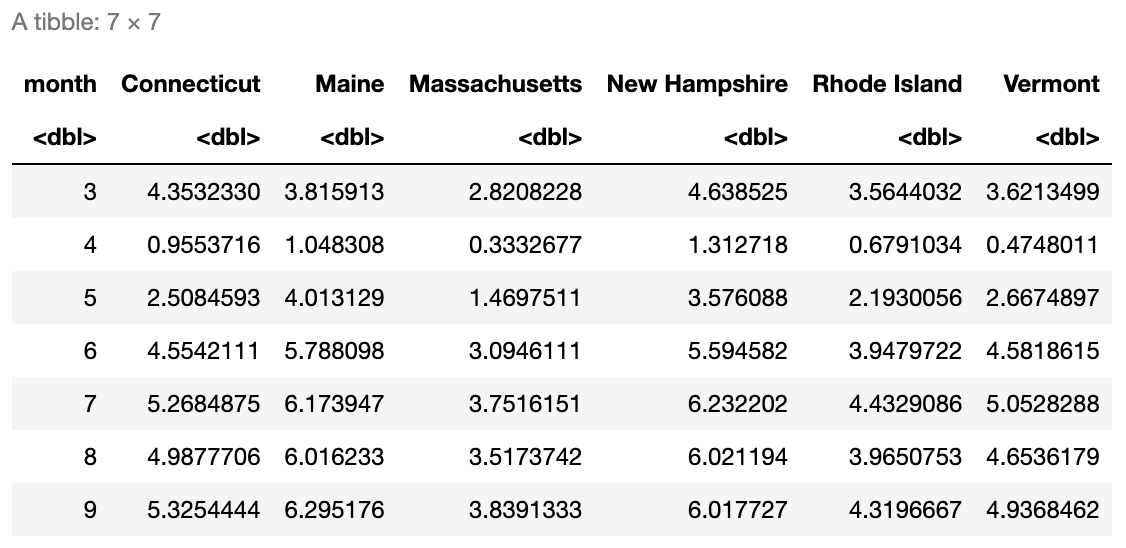
<figcaption>Figure 2: Pivoting Mobility Data.</figcaption>
</figure>

In [ ]:
# Insert your solution here:

The pivots seen so far were relatively simple in that there was only one
set of values we were pivoting on (e.g. the lockdown date, covid cases).
The [**tidyr** package](https://tidyr.tidyverse.org/articles/pivot.html)
provides examples of more complex pivots that you might want to apply to
your data \[@R-tidyr\].

## Merging Data with Joins

In the last section, we saw how to manipulate our current data into new
formats. Now, we see how we can combine multiple data sources. Merging
two data frames is called *joining*, and the functions we use to perform
this joining depends on how we want to match values between the data
frames. For example, we can join information about age and statin use
from `table1` and `table2` matching by name.

In [ ]:
table1 <- data.frame(age = c(14, 26, 32), 
                     name = c("Alice", "Bob", "Alice"))
table2 <- data.frame(name = c("Carol", "Bob"), 
                     statins = c(TRUE, FALSE))
full_join(table1, table2, by = "name")

  age  name statins
1  14 Alice      NA
2  26   Bob   FALSE
3  32 Alice      NA
4  NA Carol    TRUE

The following list gives an overview of the different possible joins.
For each join type, we specify two tables, `table1` and `table2`, and
the `by` argument, which specifies the columns used to match rows
between tables.

**Types of Joins**:

-   `left_join(table1, table2, by)`: Joins each row of table1 with all
    matches in table2.  
-   `right_join(table1, table2, by)`: Joins each row of table2 with all
    matches in table1 (the opposite of a left join)  
-   `inner_join(table1, table2, by)`: Looks for all matches between rows
    in table1 and table2. Rows that do not find a match are dropped.  
-   `full_join(table1, table2, by)`: Keeps all rows from both tables and
    joins those that match. Rows that do not find a match have NA values
    filled in.  
-   `semi_join(table1, table2, by)`: Keeps all rows in table1 that have
    a match in table2 but does not join to any information from
    table2.  
-   `anti_join(table1, table2, by)`: Keeps all rows in table1 that *do
    not* have a match in table2 but does not join to any information
    from table2. The opposite of a semi join.

We first demonstrate a left join using the `left_join()` function. This
function takes in two data tables (table1 and table2) and the columns to
match rows by. In a left join, for every row of table1, we look for all
matching rows in table2 and add any columns not used to do the matching.
Thus, every row in table1 corresponds to at least one entry in the
resulting table but possibly more if there are multiple matches. In the
subsequent code chunk, we use a left join to add the lockdown
information to our `covidcases` data. In this case, the first table is
`covidcases` and we match by `state`. Since the state column has a
slightly different name in the two data frames (“state” in `covidcases`
and “State” in `lockdowndates`), we specify that `state` is equivalent
to `State` in the `by` argument.

In [ ]:
covidcases_full <- left_join(covidcases, lockdowndates, 
                             by = c("state" = "State"))
head(covidcases_full)

# A tibble: 6 × 8
  state   county   week weekly_cases weekly_deaths date       Lockdown_Start
  <chr>   <chr>   <dbl>        <int>         <int> <date>     <date>        
1 Alabama Autauga    12            3             0 2020-03-15 2020-04-04    
2 Alabama Autauga    13            3             0 2020-03-22 2020-04-04    
3 Alabama Autauga    14            2             1 2020-03-29 2020-04-04    
4 Alabama Autauga    15           11             1 2020-04-05 2020-04-04    
5 Alabama Autauga    16            5             1 2020-04-12 2020-04-04    
6 Alabama Autauga    17            8             2 2020-04-19 2020-04-04    
# ℹ 1 more variable: Lockdown_End <date>

These two new columns allow us to determine whether the start of each
recorded week was during a lockdown. We use the `between()` function to
create a new column `lockdown` before dropping the two date columns. We
can check that this column worked as expected by choosing a single
county to look at.

In [ ]:
covidcases_full <- covidcases_full %>%
  mutate(lockdown = between(date, Lockdown_Start, Lockdown_End)) %>%
  select(-c(Lockdown_Start, Lockdown_End)) 
covidcases_full %>%
  filter(state == "Alabama", county == "Jefferson", 
         date <= as.Date("2020-05-10"))

# A tibble: 10 × 7
   state   county     week weekly_cases weekly_deaths date       lockdown
   <chr>   <chr>     <dbl>        <int>         <int> <date>     <lgl>   
 1 Alabama Jefferson    11           19             0 2020-03-08 FALSE   
 2 Alabama Jefferson    12           66             0 2020-03-15 FALSE   
 3 Alabama Jefferson    13          153             0 2020-03-22 FALSE   
 4 Alabama Jefferson    14          156             8 2020-03-29 FALSE   
 5 Alabama Jefferson    15          128             2 2020-04-05 TRUE    
 6 Alabama Jefferson    16           72             9 2020-04-12 TRUE    
 7 Alabama Jefferson    17          117            10 2020-04-19 TRUE    
 8 Alabama Jefferson    18          139             5 2020-04-26 TRUE    
 9 Alabama Jefferson    19          105             9 2020-05-03 FALSE   
10 Alabama Jefferson    20          168            14 2020-05-10 FALSE   

We now want to add in the mobility data. In the previous join, we wanted
to keep any observation in `covidcases` regardless if it was in the
`lockdowndates` data frame. Therefore, we used a left join. In this
case, we only want to keep observations that have mobility data for that
state on each date. This indicates that we want to use an *inner join*.
The function `inner_join()` takes in two data tables (table1 and table2)
and the columns to match rows by. The function only keeps rows in table1
that match to a row in table2. Again, those columns in table2 not used
to match with table1 are added to the resulting outcome. In this case,
we match by both state and date.

In [ ]:
covidcases_full <- inner_join(covidcases_full, mobility, 
                              by = c("state", "date")) %>%
  select(-c(samples, m50_index))
head(covidcases_full)

# A tibble: 6 × 8
  state   county   week weekly_cases weekly_deaths date       lockdown   m50
  <chr>   <chr>   <dbl>        <int>         <int> <date>     <lgl>    <dbl>
1 Alabama Autauga    12            3             0 2020-03-15 FALSE    8.77 
2 Alabama Autauga    13            3             0 2020-03-22 FALSE    4.73 
3 Alabama Autauga    14            2             1 2020-03-29 FALSE    4.43 
4 Alabama Autauga    15           11             1 2020-04-05 TRUE     2.27 
5 Alabama Autauga    16            5             1 2020-04-12 TRUE     0.759
6 Alabama Autauga    17            8             2 2020-04-19 TRUE     1.51 

### Practice Question

Look at the two data frames, `df_A` and `df_B`, defined in the following
code. What kind of join would produce the data frame in
<a href="#fig-joining-data" class="quarto-xref">Figure 3</a>? Perform
this join yourself.

<figure id="fig-joining-data">
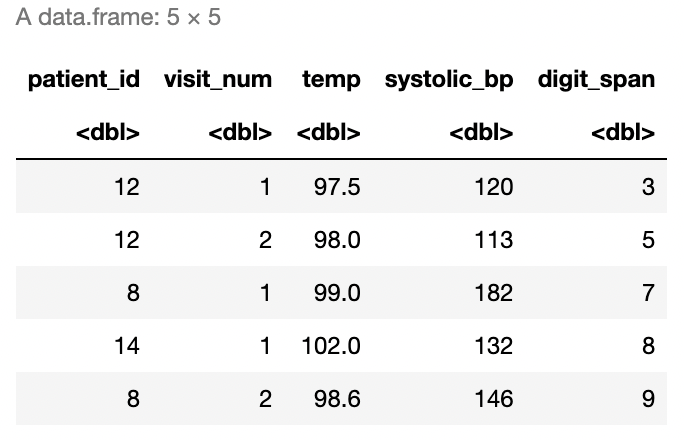
<figcaption>Figure 3: Joining Data.</figcaption>
</figure>

In [ ]:
df_A <- data.frame(patient_id = c(12, 9, 12, 8, 14, 8), 
                  visit_num = c(1, 1, 2, 1, 1, 2), 
                  temp = c(97.5, 96, 98, 99, 102, 98.6), 
                  systolic_bp = c(120, 138, 113, 182, 132, 146))
df_A

  patient_id visit_num  temp systolic_bp
1         12         1  97.5         120
2          9         1  96.0         138
3         12         2  98.0         113
4          8         1  99.0         182
5         14         1 102.0         132
6          8         2  98.6         146

  patient_id visit_num digit_span
1         12         1          3
2         12         2          5
3         12         3          7
4          8         1          7
5          8         2          9
6          8         3          5
7         14         1          8
8         14         2          7

In [ ]:
# Insert your solution here:

## Exercises

1.  Take a look at the provided code - what is wrong with it? Hint:
    think about what causes the warning message.

    ``` r
    visit_info <- data.frame(
      name.f = c("Phillip", "Phillip", "Phillip", "Jessica", 
                 "Jessica"),
      name.l = c("Johnson", "Johnson", "Richards", "Smith", 
                 "Abrams"),
      measure = c("height", "age", "age", "age", "height"),
      measurement = c(45, 186, 50, 37, 156)
    )

    contact_info <- data.frame(
    first_name = c("Phillip", "Phillip", "Jessica", "Margaret"),
    last_name = c("Richards", "Johnson", "Smith", "Reynolds"),
    email = c("pr@aol.com", "phillipj@gmail.com", 
              "jesssmith@brown.edu", "marg@hotmail.com")
    )

    left_join(visit_info, contact_info, 
              by = c("name.f" = "first_name"))
    ```

        Warning in left_join(visit_info, contact_info, by = c(name.f = "first_name")): Detected an unexpected many-to-many relationship between `x` and `y`.
        ℹ Row 1 of `x` matches multiple rows in `y`.
        ℹ Row 1 of `y` matches multiple rows in `x`.
        ℹ If a many-to-many relationship is expected, set `relationship =
          "many-to-many"` to silence this warning.

           name.f   name.l measure measurement last_name               email
        1 Phillip  Johnson  height          45  Richards          pr@aol.com
        2 Phillip  Johnson  height          45   Johnson  phillipj@gmail.com
        3 Phillip  Johnson     age         186  Richards          pr@aol.com
        4 Phillip  Johnson     age         186   Johnson  phillipj@gmail.com
        5 Phillip Richards     age          50  Richards          pr@aol.com
        6 Phillip Richards     age          50   Johnson  phillipj@gmail.com
        7 Jessica    Smith     age          37     Smith jesssmith@brown.edu
        8 Jessica   Abrams  height         156     Smith jesssmith@brown.edu

2.  First, use the `covidcases` data to create a new data frame called
    `sub_cases` containing the total number of cases by month for the
    states of California, Michigan, Connecticut, Rhode Island, Ohio, New
    York, and Massachusetts. Then, manipulate the `mobility` data to
    calculate the average `m50` mobility measure for each month.
    Finally, merge these two data sets using an appropriate joining
    function.

3.  Convert the `sub_cases` data frame from the previous exercise to
    wide format so that each row displays the cases in each state for a
    single month. Then, add on the average m50 overall for each month as
    an additional column using a join function.